In [1]:
import numpy as np
import matplotlib.pyplot as pl
import json
import pandas
from keras import Sequential
from keras.datasets import mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.utils import np_utils, to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn import metrics as me

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from labelsUtils import (
    Label,
)

from regionUtils import (
    vietnam_labels_coordinates,
)

from rasterUtils import (
    make_dataset_from_raster_files,
)

from convNetUtils import (
    split_dataset,
    images_from_dataset,
    labels_from_dataset,
    plot_confusion_matrix,
)

In [2]:
from enum import Enum

class Band(Enum):
    COASTAL_AEROSOL = 0
    BLUE = 1
    GREEN = 2
    RED = 3
    NIR = 4
    SWIR1 = 5
    SWIR2 = 6
    PANCHROMATIC = 7
    CIRRUS = 8
    TIRS1 = 9
    TIRS2 = 10

In [42]:
NB_PIXEL_AROUND = 5
TRAIN_TEST_RATIO = 0.8
EPOCHS = 100
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()

In [43]:
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

labels_names = [label.name for label in labels]

dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_march/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

bands = [
    Band.BLUE.value,
    Band.RED.value,
    Band.NIR.value
]

dataset = make_dataset_from_raster_files(**dataset_args)
train, test = split_dataset(dataset)

(train, test) = split_dataset(dataset)

X_train = images_from_dataset(train, bands)
y_train = labels_from_dataset(train, labels_names)
Y_train = to_categorical(y_train, num_classes=len(labels))

X_test = images_from_dataset(test, bands)
y_test = labels_from_dataset(test, labels_names)
Y_test = to_categorical(y_test, num_classes=len(labels))

In [44]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [40]:
# images have all the same shapes, take the shape of the first image
image_height, image_width, image_depth = X_train[0].shape

In [45]:
inputs = Input(shape=(image_width, image_height, image_depth))

# Add layers of convolution and pooling
model_layers = Rescaling(1./2**16)(inputs)
model_layers = Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu")(model_layers)
model_layers = Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu")(model_layers)
model_layers = MaxPooling2D(pool_size=(2, 2))(model_layers)
model_layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same", activation="relu")(model_layers)
model_layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same", activation="relu")(model_layers)
model_layers = MaxPooling2D(pool_size=(2, 2))(model_layers)
model_layers = Flatten(name='flat')(model_layers)
model_layers = Dense(256, activation='relu')(model_layers)
model_layers = Dropout(0.5)(model_layers)
outputs = Dense(len(labels), activation='softmax')(model_layers)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 11, 11, 3)]       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 11, 11, 3)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 8)         224       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 11, 11, 8)         584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 8)           0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 5, 5, 16)          528       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 5, 5, 16)          1040

In [46]:
# Specify optimizer and loss function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
data_gen_args = dict(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# create data generator
datagen = ImageDataGenerator(**data_gen_args)
datagen.fit(X_train)
train_datagen = datagen.flow(X_train, Y_train, batch_size=32)

In [48]:
model_args = dict(
    x=train_datagen,
    epochs=EPOCHS,
    validation_split=0.0,
    validation_data=(X_test, Y_test),
    class_weight=class_weights,
    steps_per_epoch=len(y_train) / 32,
)

history = model.fit(**model_args)

Epoch 1/100
229/229 [==============================] - 2s 6ms/step - loss: 1.7801 - accuracy: 0.1859 - val_loss: 1.4017 - val_accuracy: 0.3946
Epoch 2/100
229/229 [==============================] - 1s 6ms/step - loss: 1.4159 - accuracy: 0.3541 - val_loss: 1.3206 - val_accuracy: 0.4929
Epoch 3/100
229/229 [==============================] - 1s 6ms/step - loss: 1.3246 - accuracy: 0.4078 - val_loss: 1.2228 - val_accuracy: 0.5603
Epoch 4/100
229/229 [==============================] - 1s 6ms/step - loss: 1.2754 - accuracy: 0.4240 - val_loss: 1.3193 - val_accuracy: 0.3277
Epoch 5/100
229/229 [==============================] - 1s 6ms/step - loss: 1.1738 - accuracy: 0.3929 - val_loss: 1.2638 - val_accuracy: 0.3641
Epoch 6/100
229/229 [==============================] - 1s 6ms/step - loss: 1.1151 - accuracy: 0.4239 - val_loss: 1.2157 - val_accuracy: 0.4511
Epoch 7/100
229/229 [==============================] - 1s 6ms/step - loss: 1.0977 - accuracy: 0.4648 - val_loss: 1.1721 - val_accuracy: 0.4690

Epoch 58/100
229/229 [==============================] - 1s 6ms/step - loss: 0.8547 - accuracy: 0.5872 - val_loss: 1.0429 - val_accuracy: 0.5620
Epoch 59/100
229/229 [==============================] - 1s 6ms/step - loss: 0.9027 - accuracy: 0.5668 - val_loss: 1.0449 - val_accuracy: 0.5761
Epoch 60/100
229/229 [==============================] - 1s 6ms/step - loss: 0.9071 - accuracy: 0.5811 - val_loss: 1.0484 - val_accuracy: 0.5625
Epoch 61/100
229/229 [==============================] - 1s 6ms/step - loss: 0.8721 - accuracy: 0.5894 - val_loss: 0.9891 - val_accuracy: 0.5880
Epoch 62/100
229/229 [==============================] - 1s 6ms/step - loss: 0.8836 - accuracy: 0.5805 - val_loss: 0.9754 - val_accuracy: 0.5973
Epoch 63/100
229/229 [==============================] - 1s 6ms/step - loss: 0.8773 - accuracy: 0.5839 - val_loss: 1.0209 - val_accuracy: 0.5821
Epoch 64/100
229/229 [==============================] - 1s 6ms/step - loss: 0.9041 - accuracy: 0.5754 - val_loss: 1.0154 - val_accuracy:

Test score: 0.9457322359085083
Test accuracy: 0.5874999761581421


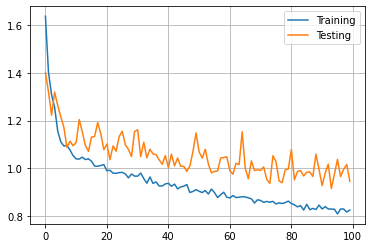

In [49]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

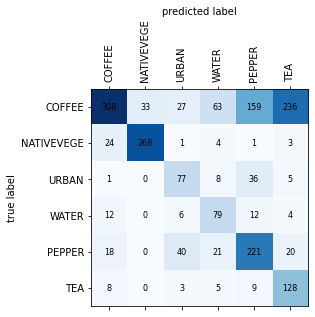

In [50]:
classes = [label.name for label in [Label.COFFEE, Label.NATIVEVEGE, Label.URBAN, Label.WATER, Label.PEPPER, Label.TEA]]

pred = model.predict_on_batch(X_test)
pred = np.argmax(pred, axis=-1)

confusion_matrix = me.confusion_matrix(y_test, pred)
plot_confusion_matrix(confusion_matrix, classes)

In [51]:
 print(me.classification_report(y_test, pred, target_names=classes))

              precision    recall  f1-score   support

      COFFEE       0.83      0.37      0.51       826
  NATIVEVEGE       0.89      0.89      0.89       301
       URBAN       0.50      0.61      0.55       127
       WATER       0.44      0.70      0.54       113
      PEPPER       0.50      0.69      0.58       320
         TEA       0.32      0.84      0.47       153

    accuracy                           0.59      1840
   macro avg       0.58      0.68      0.59      1840
weighted avg       0.69      0.59      0.59      1840

